In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import little_things_functions as ltf
import math

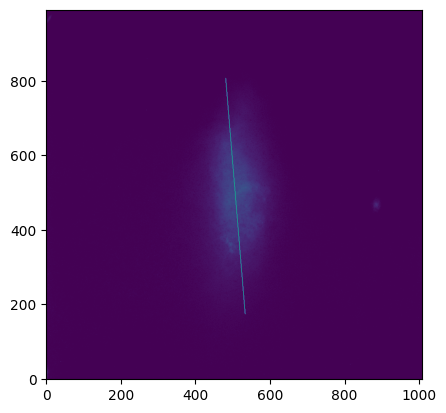

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


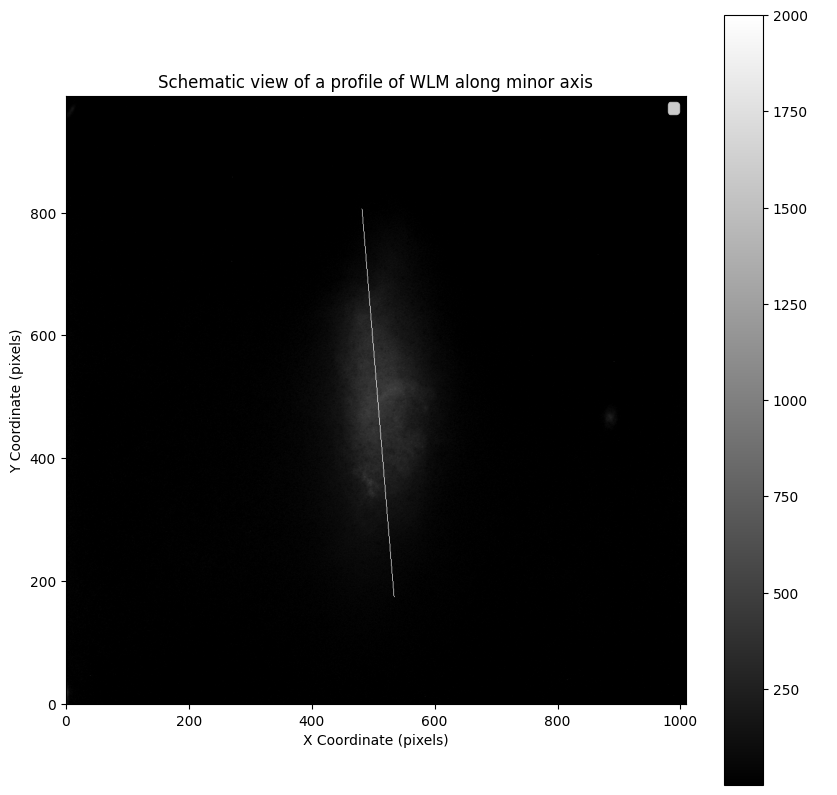

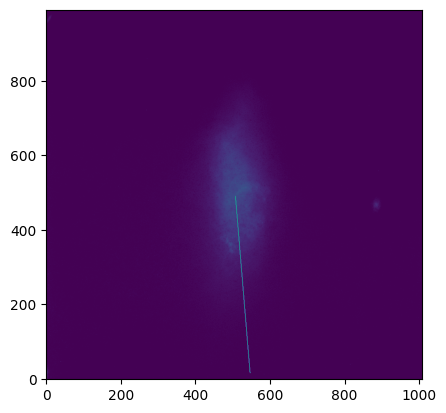

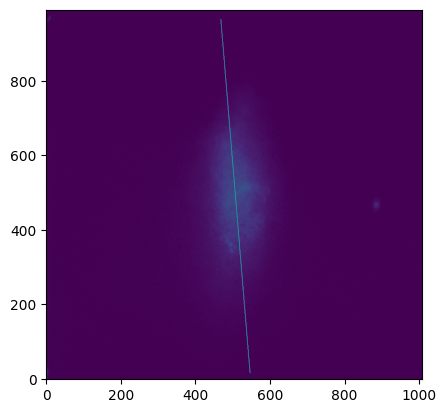

y_ax_left length: 474
y_ax_right length: 474
values_along_line_left length: 474
values_along_line_right length: 474
y_ax combined length: 948
values_along_line combined length: 948


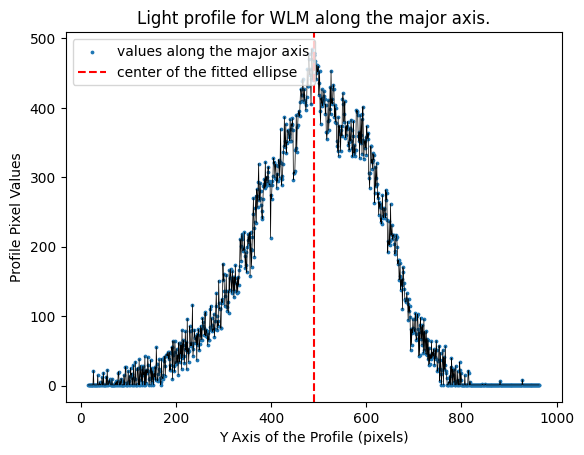

Threshold value: 273.621480698029
Center of galaxy (Equal Area on both sides of the center line): 494


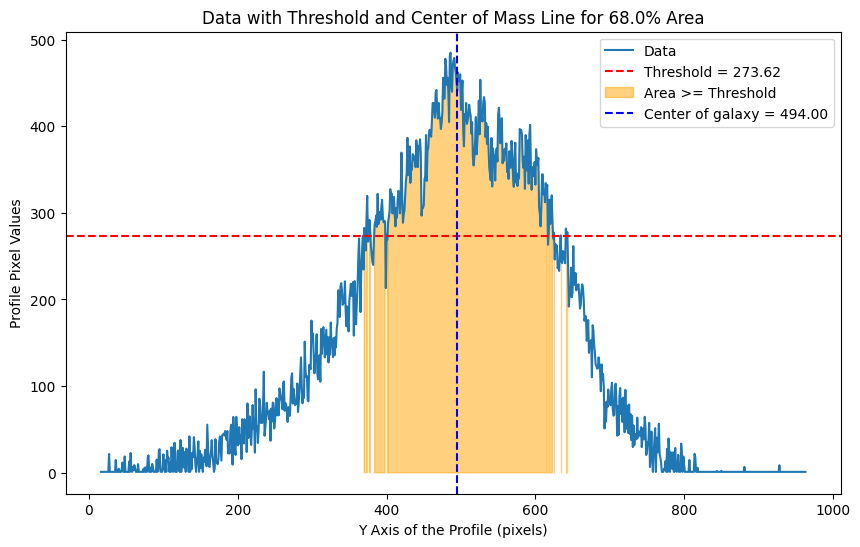

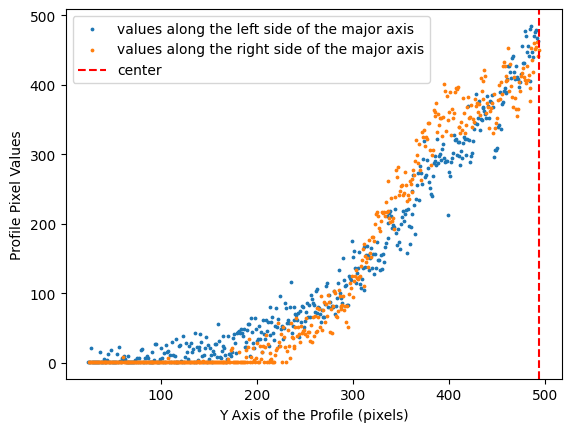

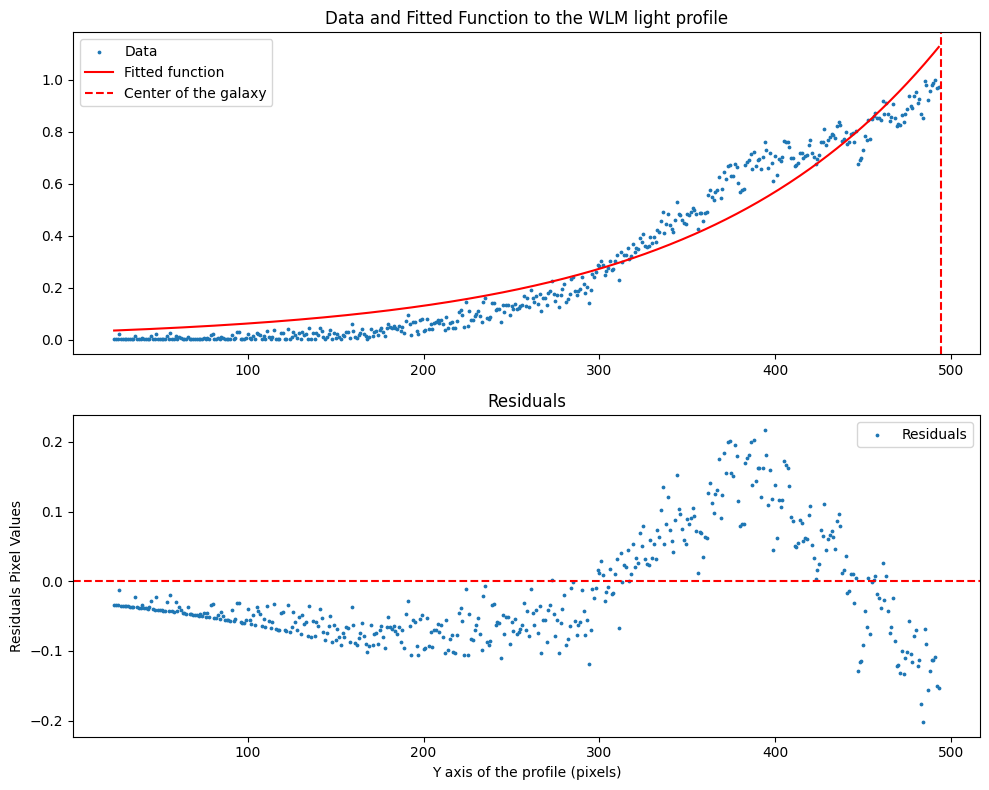

Exponential fit function is exp(b * (x - x0))
b is 0.0073 +/- 0.0001
x0 is 476.9127 +/- 1.4692
RD is 136.3933 pixels
RD for WLM is 0.74986063141286 kpc


In [5]:
galaxy_name = "WLM"
D = 1.0
x_start = 100
y_start = 100
a_half = 158
b_half = 58
theta_deg = 4.7243235 + 90 
X_center = 407 + x_start
y_center = 390 + y_start


visual_WLM = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\WLM\final_wLMv.fits"))
theta_rad = np.radians(theta_deg)
list_of_ellipse_data = [theta_rad, a_half, b_half]
y_ax_left = np.arange(y_center - 2 * a_half, y_center)
y_ax_right = np.arange(y_center, y_center + 2*a_half)
y_ax = np.concatenate((y_ax_left, y_ax_right))

def get_line_values(array, X_center, y_center, y_ax, theta_rad): 
    m = np.tan(theta_rad)
    values = [] 
    x_list = [] 
    for y in y_ax: 
        x = int((y - y_center + m * X_center) / m)
        values.append(array[y, x]) 
        array[y, x] = 2000 
        x_list.append(x) 
    plt.imshow(array, origin = 'lower')
    plt.show()
    return values, x_list

get_line_values(visual_WLM, X_center, y_center, y_ax, theta_rad)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(visual_WLM, cmap='gray', origin='lower')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(" ")

plt.title(f"Schematic view of a profile of {galaxy_name} along minor axis")
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.legend()
plt.show()



WLM = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\WLM\final_wLMv.fits"))


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def RD(image, n ,distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, galaxy_name, ratio=0.68, initial_guesses=[0.006, 25]):
    theta_rad, a, b = list_of_ellipse_data
    
     
    center_of_galaxy_y = int(center_of_galaxy_y)
    
    y_ax_left = np.arange(y_center - n * a_half, y_center)
    y_ax_right = np.arange(y_center, y_center + n*a_half)
    
    values_along_line_left, x_list_left = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y, y_ax_left, theta_rad)
    values_along_line_right, x_list_right = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y, y_ax_right, theta_rad)
    
    y_ax = np.concatenate((y_ax_left, y_ax_right))
    x_ax = np.concatenate((x_list_left, x_list_right))
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))

    # Add print statements to debug the lengths
    print(f"y_ax_left length: {len(y_ax_left)}")
    print(f"y_ax_right length: {len(y_ax_right)}")
    print(f"values_along_line_left length: {len(values_along_line_left)}")
    print(f"values_along_line_right length: {len(values_along_line_right)}")
    print(f"y_ax combined length: {len(y_ax)}")
    print(f"values_along_line combined length: {len(values_along_line)}")

    if len(y_ax) == len(values_along_line):
        plt.scatter(y_ax, values_along_line, s=3, label='values along the major axis')
        plt.plot(y_ax, values_along_line, color="black", linewidth=0.5)
        plt.title(f"Light profile for {galaxy_name} along the major axis.")
        plt.axvline(x=center_of_galaxy_y, color='r', linestyle='--', label='center of the fitted ellipse')
        plt.xlabel("Y Axis of the Profile (pixels)")
        plt.ylabel("Profile Pixel Values")
        plt.legend()
        plt.show()
    else:
        print("The lengths of y_ax and values_along_line do not match.")
        print(len(y_ax))
        print(len(values_along_line))
        return
    
    values_along_line = np.array(values_along_line)
    y_ax = np.array(y_ax)
    
    total_area = np.trapz(values_along_line, x=y_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (y_ax[1] - y_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_y_ax = y_ax[values_along_line > threshold_value]
    
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_y = y_ax[com_index]
    center_of_mass_x = x_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy (Equal Area on both sides of the center line): {center_of_mass_y}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(y_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_y, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_y:.2f}')
    plt.legend()
    plt.xlabel("Y Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    y_ax_left = y_ax[:com_index]
    y_ax_right = y_ax[com_index:]

    if len(y_ax_left) > len(y_ax_right):
        delete = len(y_ax_left) - len(y_ax_right)
        y_ax_left = y_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(y_ax_left) < len(y_ax_right):
        delete = len(y_ax_right) - len(y_ax_left)
        y_ax_right = y_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    flipped_y_ax_right = []
    for i in range(len(y_ax_right)):
        y = (2 * center_of_mass_y - y_ax_right[i])
        flipped_y_ax_right.append(int(y))

    flipped_y_ax_right = np.array(flipped_y_ax_right)

    plt.scatter(y_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_y_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_y, color='r', linestyle='--', label='center')
    plt.xlabel("Y Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.legend()
    plt.show()
    
    x1 = y_ax_left  
    x2 = flipped_y_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2) / 2
    mean_y_normal = mean_y / np.max(mean_y)
    def exponential_func(x,b,x0):
        return np.exp(b * (x - x0))

    popt, pcov = curve_fit(exponential_func, y_ax_left, mean_y_normal, p0=initial_guesses)

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(y_ax_left, mean_y_normal, s=3, label='Data')
    plt.plot(y_ax_left, exponential_func(y_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_y, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y_normal - exponential_func(y_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(y_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('Y axis of the profile (pixels)') 
    plt.ylabel('Residuals Pixel Values') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is exp(b * (x - x0))")

    print(f"b is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"x0 is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"RD is {1/popt[0]:.4f} pixels")
    
    RD_pixels = 1 / popt[0]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((distance * RD_arcsec) / 206265) * 1000
    print(f"RD for {galaxy_name} is {RD_value} kpc")
    return RD_pixels , RD_arcsec , y_ax_left, mean_y

RD_pixels , RD_arcsec, x_values, y_values = RD(WLM, 3,D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name)

sigma is 85.14946134846096
RD values: [0.7337150639487916, 0.8242749236193726, 0.7289572380492413, 0.7428293757011128, 0.7554734864131686, 0.7786640590518124, 0.7743207528095734, 0.7321633377240883, 0.7215914029276173, 0.7848872956468513, 0.766170831715446, 0.7950948072009366, 0.7248905024625508, 0.753426691835056, 0.7469327551689403, 0.7518665436144476, 0.7837540506240676, 0.7667611402904966, 0.7361824586156971, 0.7668229909479435, 0.7448154200761208, 0.7479098024631882, 0.7175729333474568, 0.7563938245166183, 0.7592985930893643, 0.7365012296047393, 0.7476529946477944, 0.785094792217004, 0.7424236464769004, 0.733013173002348, 0.7572425401086127, 0.7278273507710441, 0.7257396451629271, 0.7505451809461734, 0.7157308134982612, 0.767179214141023, 0.7472926196918609, 0.7439744283327804, 0.7653299272085718, 0.7432860229347759, 0.7377116769502222, 0.7266108589119438, 0.7200713348142598, 0.73437196916932, 0.7354324567797688, 0.7436091780147827, 0.7632402176266574, 0.7622120691066682, 0.723523

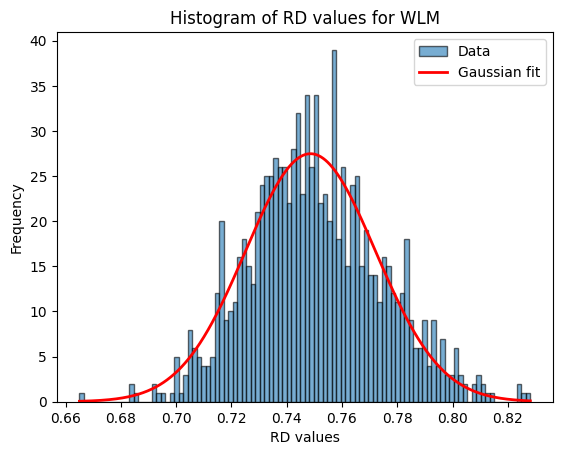

: 

In [ ]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Define the exponential function
def exponential_func(x, b, x0):
        return np.exp(b * (x-x0))

# Assume DDO_101 and y_values are defined
sigma = np.std(WLM)
print("sigma is" ,sigma)

# Number of iterations
n = 1000

# Lists to store the fitted parameters
b_list = []
x0_list = []
RD_list = []

# Loop for bootstrapping
for i in range(n):
    # Generate unique random noise for each data point from the normal distribution
    noise = np.random.normal(0, sigma, size=len(y_values))
    # Add unique noise to each data point in y_values
    y_noisy = y_values + noise
    # Fit the exponential function to the noisy data
    popt, pcov = curve_fit(exponential_func, x_values, y_noisy, p0=([0.006, 25]))
    
    # Append the parameters to the respective lists
    
    b_list.append(popt[0])
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * 1.134
    RD_value = ((D * RD_arcsec) / 206265)*1000
    RD_list.append(RD_value)
    
    x0_list.append(popt[1])



print(f"RD values: {RD_list}")
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Generate histogram data
counts, bin_edges = np.histogram(RD_list, bins=100)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guess for the parameters (A, mu, sigma)
initial_guess = [max(counts), np.mean(RD_list), np.std(RD_list)]

# Fit the Gaussian function to the histogram data
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=initial_guess)


# Print the fitted parameters
print(f"Fitted parameters: mean={popt[1]}, sigma={popt[2]}")

rd_value = f"{popt[1]:.3f}" 
rd_error = f"{popt[2]:.3f}"  

print(f"RD for {galaxy_name} is {rd_value} +/- {rd_error}")

import os


# Correct the folder name path
output_folder = r"C:\Users\AYSAN\Desktop\project\Galaxy\RD_Histogram"
output_filename = f"{galaxy_name}_RD_Histogram.png"
output_path = os.path.join(output_folder, output_filename)

# Ensure folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
x_fit = np.linspace(min(RD_list), max(RD_list), 1000)
y_fit = gaussian(x_fit, *popt)
# Plotting and saving the histogram
plt.hist(RD_list, bins=100, edgecolor='k', alpha=0.6, label='Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Gaussian fit')
plt.xlabel('RD values')
plt.ylabel('Frequency')
plt.title(f'Histogram of RD values for {galaxy_name}')
plt.legend()

# Save the plot
plt.savefig(output_path)
